<div style="margin: 20px; text-align: center; font-size: 30px;"> Image and Speech Recognition</div>
<div style="margin: 20px; text-align: center; font-size: 30px;">Face Detection</div>
<br><br>
<div style="margin: 10px; text-align: right; font-size: 20px;"> Student: Maciej Pęśko</div>
<div style="margin: 10px; text-align: right; font-size: 20px;"> Supervisor: mgr inż. Maciej Stefańczyk</div>


### INSTRUCTION
#### 1. TO EVALUATE RESULTS RUN WHOLE NOTEBOOK HAVING:
 - 'test_dataset.data', 'train_and_validation_dataset.data', 'test_dataset_own.data', 'train_and_validation_dataset_own.data' in 'data' directory
 - 'evaluation' directory with test images called '1.jpg' - '12.jpg'
 
 All above data available here:
 https://github.com/maciej3031/face_detection/tree/master/data
 
#### 2. NOTEBOOK WITH RESULTS AVAILABLE HERE: https://github.com/maciej3031/documents_face_detection

In [591]:
import os
import pickle
import random

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

random.seed()

In [592]:
def jj(*args):
    return os.path.join(*args)

FACES = jj('data','faces')
OTHER = jj('data','objects')
OTHER_WITH_FACES = jj('data','objects_with_faces')
FACES_64 = jj('data','faces_64')
OTHER_64 = jj('data','objects_64')
OTHER_WITH_FACES_64 = jj('data','objects_with_faces_64')

# IMAGE SIZE USED FOR SVM LEARNING
IMG_SIZE = 64

# NUMBER OF IMAGES FOR SVM LEARNING
NUMBER_OF_FACES = 7500
NUMBER_OF_OTHERS = 6500
NUMBER_OF_OTHERS_WITH_FACES = 1000

#### FUNCTION FOR LOADING SAVED DATASETS.

In [593]:
# Load train_and_validation dataset
train_and_validation = pickle.load(open(os.path.join("data", "train_and_validation_dataset.data"), "rb" ))
test = pickle.load(open(os.path.join("data", "test_dataset.data"), "rb" ))

train_and_validation_own = pickle.load(open(os.path.join("data", "train_and_validation_dataset_own.data"), "rb" ))
test_own = pickle.load(open(os.path.join("data", "test_dataset_own.data"), "rb" ))

## 1. COMPUTER VISION UTILS

#### SOME UTILS USED TO WORK WITH IMAGES.

In [594]:
def open_image(full_image_name, color=True):
    if color:
        return cv2.imread(full_image_name, 3)
    else:
        return cv2.imread(full_image_name, 0)
    
def resize(img, n, m):
    return cv2.resize(img, (n, m))

def resize_image_to_nxn_square(img, n):
    longer_side = max(img.shape)
    horizontal_padding = int((longer_side - img.shape[0]) / 2)
    vertical_padding = int((longer_side - img.shape[1]) / 2)
    
    new_image = cv2.copyMakeBorder(img,
                                   horizontal_padding,
                                   horizontal_padding,
                                   vertical_padding,
                                   vertical_padding,
                                   cv2.BORDER_REPLICATE)    
    resized_img = resize(new_image, n, n)
    return resized_img

def normalize(dataset):
    max_val = np.max(dataset)
    min_val = np.min(dataset)
    if max_val == min_val:
        max_val += 0.000001
    return (dataset-min_val)/(max_val - min_val)


def hitogram_equalization(im):
    histogram = [0.0] * 256
    h, w = im.shape
    for i in range(h):
        for j in range(w):
            histogram[im[i, j]] += 1
    normalized_histogram = np.array(histogram)/(h*w)
    cumulative_historgam = np.array([sum(normalized_histogram[:i+1]) for i in range(len(normalized_histogram))])
    
    new_value = np.uint8(255 * cumulative_historgam)
    new_image = np.zeros(im.shape, dtype=np.uint8)
    
    for i in range(h):
        for j in range(w):
            new_image[i, j] = new_value[im[i, j]]

    return new_image

def rotate(image, angle):
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
 
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
 
    M[0, 2] += (w / 2) - cX
    M[1, 2] += (h / 2) - cY
 
    return cv2.warpAffine(image, M, (w, h))

## 2. MACHINE LEARNING UTILS

#### SOME MACHINE LEARNING UTILS USED FOR SVM LEARNING AND EVALUATION. 

In [595]:
def accuracy_score(actual, predicted):
    predicted = predicted.reshape(-1, )
    actual = actual.reshape(-1, )

    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))

    return (TP + TN) / actual.shape[0]

def split_data(dataset, train_size=0.8):
    if isinstance(dataset, np.ndarray):
        np.random.shuffle(dataset)
        size = dataset.shape[0]
    elif isinstance(dataset, list):
        random.shuffle(dataset)
        size=len(dataset)
    else:
        raise TypeError('Argument is invalid! Numpy Array or Python List required.')
    
    return dataset[:int(train_size * size)], dataset[int(train_size * size):]

def k_fold_split_data(dataset, k=5):
    if isinstance(dataset, np.ndarray):
        np.random.shuffle(dataset)
    elif isinstance(dataset, list):
        random.shuffle(dataset)
    else:
        raise TypeError('Argument is invalid! Numpy Array or Python List required.')

    return np.array_split(dataset, k)

def plot_confusion_matrix(model, x, y, threshold=0):
    predicted = model.predict(x, flags=1)[1]
    predicted = np.where(predicted < threshold, 1, 0)
    actual = y.reshape(predicted.shape)

    TP = np.count_nonzero(predicted * actual)
    TN = np.count_nonzero((predicted - 1) * (actual - 1))
    FP = np.count_nonzero(predicted * (actual - 1))
    FN = np.count_nonzero((predicted - 1) * actual)

    confusion_matrix_dict = {'actual 1': [TP, FN], 'actual 0': [FP, TN]}
    confusion_matrix = pd.DataFrame(data=confusion_matrix_dict, columns =['actual 1', 'actual 0'], index=['predicted 1', 'predicted 0'])
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * precision * recall / (precision + recall)
    
    print('Acuraccy: {}'.format(accuracy_score(actual, predicted)))
    print('\nPrecision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F-score: {}'.format(f1))
    print("\n")
    print(confusion_matrix)
    
def plot_ROC(TPR_array, FPR_array):   
    plt.figure(figsize=(8,8))
    plt.title('ROC')
    plt.plot(FPR_array, TPR_array, 'b', linewidth=3.0)
    plt.legend(loc = 'lower right')
    plt.plot([-0.01, 1.01], [-0.01, 1.01],'r--')
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    
def plot_FAR_FRR(model, x, y):
    FAR_array = []
    FRR_array = []
    thresholds = []
    for i in tqdm(range(-300,300, 5)):
        svm_raw_results = (model.predict(x, flags=1)[1])
        predicted = (svm_raw_results + i/100).reshape(y.shape)

        predicted = np.where(predicted<=0,1,0)
        actual = y  
        TP = np.count_nonzero(np.multiply(predicted, actual))
        TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))
        FP = np.count_nonzero(np.multiply(predicted, actual - 1))
        FN = np.count_nonzero(np.multiply(predicted - 1, actual))
        
        FAR = FPR = FP/(FP + TN)
        FRR = FNR = FN/(FN + TP)
        
        FAR_array.append(FAR)
        FRR_array.append(FRR)
        thresholds.append(0.5+i/100)
    
    plt.figure(figsize=(8,8))
    plt.title('FAR/FRR')
    plt.plot(thresholds, FAR_array, 'b', label='FAR')
    plt.plot(thresholds, FRR_array, 'r', label='FRR')
    
    plt.xlim([-3, 3])
    plt.ylim([-0.01, 0.3])
    plt.ylabel('FAR/FRR')
    plt.xlabel('Threshold')
    
    leg = plt.legend(loc='best', ncol=2, mode="expand", shadow=True, fancybox=True)
    leg.get_frame().set_alpha(0.5)
    
    plt.show()

## 3. IMPLEMENTED ALGORITHMS

## 3.1 CANNY ALGORITHM

#### FIRST TRY TO GET FEATURES - OBTAIN EDGES USING CANNY ALGORITHM. UNFORTUNATELY NO GOOD RESULTS WITH THIS APPROACH.

In [596]:
class Canny(object):
    def __init__(self, img, minVal, maxVal):
        self.minVal = minVal
        self.maxVal = maxVal
        self.gaussian_filter = np.asarray([[1, 4, 7, 4, 1],
                                           [4, 16, 26, 16, 4],
                                           [7, 26, 41, 26, 7],
                                           [4, 16, 26, 16, 4],
                                           [1, 4, 7, 4, 1]], dtype=np.int)

        self.sobel_Gx_filter = np.asarray([[-1, 0, 1],
                                           [-2, 0, 2],
                                           [-1, 0, 1]], dtype=np.int)

        self.sobel_Gy_filter = np.asarray([[-1, -2, -1],
                                           [0, 0, 0],
                                           [1, 2, 1]], dtype=np.int)

        self.array = np.asarray(img, dtype=np.int)
        self.height, self.width = self.array.shape[0], self.array.shape[1]
        self.canny_edges = np.zeros(self.array.shape)

        self.run()

    def run(self):
        array_after_gaussian_filtering = self.get_gaussian_filtered_array()
        array_after_Gx = self.get_array_after_Gx(array_after_gaussian_filtering)
        array_after_Gy = self.get_array_after_Gy(array_after_gaussian_filtering)
        array_G = self.get_array_after_G(array_after_Gx, array_after_Gy)
        array_theta = self.get_array_after_theta(array_after_Gx, array_after_Gy)
        array_nmax_suppress = self.get_array_after_suppression(array_G, array_theta)

        self.set_array_after_thresholding(array_nmax_suppress)

    def get_features(self):
        return self.canny_edges

    def get_gaussian_filtered_array(self):
        zero_padded_array = np.pad(self.array, 2, mode='constant')
        array_after_gaussian_filtering = self.convolve(zero_padded_array, self.gaussian_filter)
        return array_after_gaussian_filtering // 273

    def get_array_after_Gx(self, array_after_gaussian_filtering):
        zero_padded_array = np.pad(array_after_gaussian_filtering, 1, mode='constant')
        return self.convolve(zero_padded_array, self.sobel_Gx_filter)

    def get_array_after_Gy(self, array_after_gaussian_filtering):
        zero_padded_array = np.pad(array_after_gaussian_filtering, 1, mode='constant')
        return self.convolve(zero_padded_array, self.sobel_Gy_filter)

    def get_array_after_G(self, array_after_Gx, array_after_Gy):
        return np.sqrt(np.square(array_after_Gx) + np.square(array_after_Gy))

    def get_array_after_theta(self, array_after_Gx, array_after_Gy):
        return np.arctan2(array_after_Gy, array_after_Gx) * 180 / np.pi

    def get_array_after_suppression(self, array_G, array_theta):
        array_nmax_suppress = np.zeros(self.array.shape)
        for row in range(self.height):
            for col in range(self.width):
                if self.width - 1 > col > 0 and self.height - 1 > row > 0:
                    # 0 degrees
                    if (22.5 > array_theta[row][col] >= -22.5) or (
                            array_theta[row][col] < -157.5 or array_theta[row][col] >= 157.5):
                        if array_G[row][col] >= array_G[row][col + 1] and array_G[row][col] >= \
                                array_G[row][col - 1]:
                            array_nmax_suppress[row][col] = array_G[row][col]

                    # 45 degrees
                    if (67.5 > array_theta[row][col] >= 22.5) or (-112.5 > array_theta[row][col] >= -157.5):
                        if array_G[row][col] >= array_G[row - 1][col - 1] and array_G[row][col] >= \
                                array_G[row + 1][col + 1]:
                            array_nmax_suppress[row][col] = array_G[row][col]

                    # 90 degrees
                    if (112.5 > array_theta[row][col] >= 67.5) or (-67.5 > array_theta[row][col] >= -112.5):
                        if array_G[row][col] >= array_G[row - 1][col] and array_G[row][col] >= \
                                array_G[row + 1][col]:
                            array_nmax_suppress[row][col] = array_G[row][col]

                    # 135 degrees
                    if (157.5 > array_theta[row][col] >= 112.5) or (-22.5 > array_theta[row][col] >= -67.5):
                        if array_G[row][col] >= array_G[row - 1][col + 1] and array_G[row][col] >= \
                                array_G[row + 1][col - 1]:
                            array_nmax_suppress[row][col] = array_G[row][col]
        return array_nmax_suppress

    def set_array_after_thresholding(self, array_nmax_suppress):
        self._set_strong_edges(array_nmax_suppress)
        self._set_weak_edges(array_nmax_suppress)

    def _set_strong_edges(self, array_nmax_suppress):
        for row in range(self.height):
            for col in range(self.width):
                if self.width - 1 > col > 0 and self.height - 1 > row > 0:
                    if array_nmax_suppress[row][col] > self.maxVal:
                        self.canny_edges[row][col] = 1

    def _set_weak_edges(self, array_nmax_suppress):
        for row in range(self.height):
            for col in range(self.width):
                if self.width - 1 > col > 0 and self.height - 1 > row > 0:
                    if self.maxVal > array_nmax_suppress[row][col] > self.minVal and self._is_connected_with_strong_edge(row, col):
                        self.canny_edges[row][col] = 1

    def _is_connected_with_strong_edge(self, row, col):
        deltas = [(1, 0), (0, 1), (1, 1), (-1, 0), (0, -1), (-1, -1), (-1, 1), (1, -1)]
        for i, j in deltas:
            if self.canny_edges[row + i][col + j] == 1:
                self.canny_edges[row][col] = 1

    def convolve(self, array, filter_array):
        result_array = np.zeros(self.array.shape)
        offset = filter_array.shape[0] // 2
        for row in range(self.height):
            for col in range(self.width):
                if (self.height - 2 * offset >= row >= offset) and (self.width - 2 * offset >= col >= offset):
                    new_value = 0
                    for f_row in range(filter_array.shape[0]):
                        for f_col in range(filter_array.shape[1]):
                            new_value += array[row - offset + f_row][col - offset + f_col] * filter_array[f_row][f_col]
                    result_array[row - offset, col - offset] = new_value
        return result_array

#### PROOF OF PROPER CANNY ALGORITHM PERFORMANCE. 

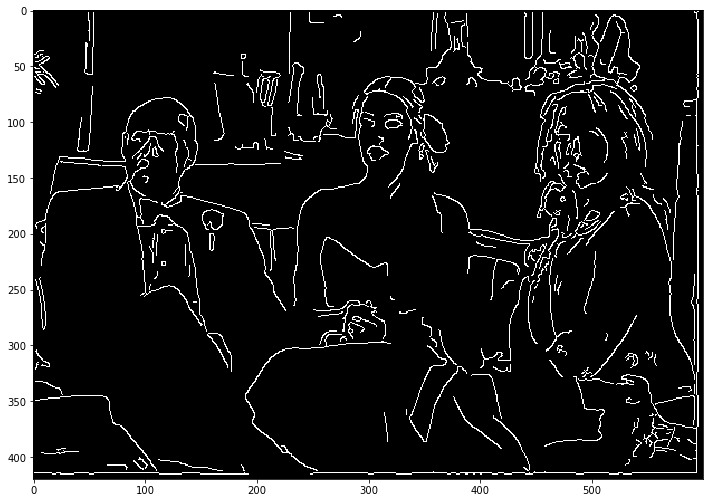

In [597]:
image = open_image(jj('data', 'evaluation', '2.jpg'), color=False)
canny = Canny(image, 60, 120)
image = canny.get_features()
plt.figure(figsize=(12,9))
plt.imshow(image, cmap=plt.cm.gray)
plt.show()

## 3.2 HISTOGRAM OF ORIENTED GRADIENTS ALGORITHM

#### CREATE INSTANCE OF HOG MODEL. FIRSTLY THERE WILL BE USED OPENCV2 HOG ALGORITHM BECAUSE OF THE VERY FAST PERFORMANCE WHICH IS NEEDED TO COMPUTE FEATURES DURING WINDOWS SLIDING ON FINAL IMAGES.

In [598]:
winSize = (64,64)
blockSize = (16,16)
blockStride = (8,8)
cellSize = (8,8)
nbins = 9

hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)

winStride = (8,8)
padding = (8,8)
locations = ((0,0),)

## 4. Prepare Dataset

#### SCRIPTS USED TO RESIZE FACES AND OTHER IMAGES TO PROPER SIZES.
#### FACES ARE TAKEN FROM LABELED FACES IN THE WILD DATASET: http://vis-www.cs.umass.edu/lfw/.
#### OTHER OBJECTS ARE TAKEN FROM CALTECH-256 DATASET: http://www.vision.caltech.edu/Image_Datasets/Caltech256/

In [599]:
# # Create 64x64 images of faces
# for i, image_name in enumerate(os.listdir(FACES)):
#     img = open_image(jj(FACES, image_name))
#     img = img[50:200,50:200]
#     img = resize(img, IMG_SIZE, IMG_SIZE)
#     cv2.imwrite(jj(FACES_64, "f_{}.jpg".format(i)), img)      

In [600]:
# # Create 64x64 images of other objects
# for i, image_name in enumerate(os.listdir(OTHER)):
#     img = open_image(jj(OTHER, image_name))
#     img = resize(img, IMG_SIZE, IMG_SIZE)
#     cv2.imwrite(jj(OTHER_64, "o_{}.jpg".format(i)), img)  

In [601]:
# # Create 64x64 images of other objects with faces
# for i, image_name in enumerate(os.listdir(OTHER_WITH_FACES)):
#     img = open_image(jj(OTHER_WITH_FACES, image_name))
#     img = resize(img, IMG_SIZE, IMG_SIZE)
#     cv2.imwrite(jj(OTHER_WITH_FACES_64, "o_{}.jpg".format(i)), img)  

In [602]:
# for j, image_name in enumerate(os.listdir(OTHER_WITH_FACES)):
#     image = open_image(jj(OTHER_WITH_FACES, image_name), color=False)
#     global_height, global_width = image.shape

#     ratio = global_height/global_width

#     results = []
#     for i in range(1, 5):
#         img = resize(image, i * IMG_SIZE, int(i * IMG_SIZE*ratio))
#         height, width = img.shape
#         for row in range(0, height, 64):
#             for col in range(0, width, 64):
#                 up, bottom, left, right = row, row + IMG_SIZE, col, col + IMG_SIZE
#                 window = img[up:bottom, left:right]
#                 if window.shape == (IMG_SIZE, IMG_SIZE):
#                     cv2.imwrite(jj('data', 'done', "oo_{}{}{}{}.jpg".format(col, row, i, j)), window)  

#### SCRIPTS USED TO OBTAIN HOG FEATURES FROM IMAGES, BUILD DATASET AND SAVE IT.

In [603]:
# # Get HOG features of all faces images
# faces = []
# for i in tqdm(range(NUMBER_OF_FACES)):
#     img = open_image(jj(FACES_64, 'f_{}.jpg'.format(i)), color=False)
# #     img = hitogram_equalization(img)
# #     img = resize(img, IMG_SIZE)
#     face_hist = hog.compute(img,winStride,padding,locations)
# #     face_hist = my_hog.get_features(img)
#     faces.append((face_hist, 1))

In [604]:
# # Get HOG features of all other images
# others = []
# for i in tqdm(range(NUMBER_OF_OTHERS)):
#     img = open_image(jj(OTHER_64, 'o_{}.jpg'.format(i)), color=False)
# #     img = hitogram_equalization(img) 
# #     img = resize(img, IMG_SIZE)
#     other_hist = hog.compute(img,winStride,padding,locations)
# #     other_hist = my_hog.get_features(img)
#     others.append((other_hist, 0))

In [605]:
# # Get HOG features of all other with faces images
# others_with_faces = []
# for i in tqdm(range(NUMBER_OF_OTHERS_WITH_FACES)):
#     img = open_image(jj(OTHER_WITH_FACES_64, 'o_{}.jpg'.format(i)), color=False)
# #     img = hitogram_equalization(img) 
# #     img = resize(img, IMG_SIZE)
#     other_hist = hog.compute(img,winStride,padding,locations)
# #     other_hist = my_hog.get_features(img)
#     others_with_faces.append((other_hist, 0))

In [606]:
# # Build dataset
# dataset = faces + others + others_with_faces
# random.shuffle(dataset)
# print(len(dataset))


#### SCRIPT FOR SPLIT DATASET TO TRAINING AND VALIDATION  DATASET AND TEST DATASET AND EXPORT DATA.

In [607]:
# train_and_validation, test = split_data(dataset, train_size=0.75)

In [608]:
x_test = np.asarray([i[0] for i in test])
y_test = np.asarray([i[1] for i in test])

In [609]:
# # export train_and_validation and test dataset
# pickle.dump( train_and_validation, open(os.path.join("data", "train_and_validation_dataset.data"), "wb" ))
# pickle.dump( test, open(os.path.join("data", "test_dataset.data"), "wb" ))

## 5. Create and evaluate SVM model

#### CREATE SVM MODEL USING OPENCV. 

In [610]:
svm = cv2.ml.SVM_create()
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setType(cv2.ml.SVM_C_SVC)
svm.setC(1)
svm.setGamma(1)

#### EVALUATE ON VALIDATION DATASET USING K_FOLD VALIDATION.

In [611]:
k_fold_split_array = k_fold_split_data(train_and_validation, 10)
train_accuracies = []
validation_accuracies = []

for n, validation in enumerate(k_fold_split_array):
    train = k_fold_split_array.copy()
    train.pop(n)
    train = np.concatenate(train)

    x_train = np.asarray([i[0] for i in train])
    y_train = np.asarray([i[1] for i in train])

    x_validation = np.asarray([i[0] for i in validation])
    y_validation = np.asarray([i[1] for i in validation])

    svm.train(x_train, cv2.ml.ROW_SAMPLE, y_train)
#     svm.fit(x_train, y_train)

    
    y_pred = svm.predict(x_train)[1]
    train_accuracies.append(accuracy_score(y_train, y_pred))
    
    y_pred = svm.predict(x_validation)[1]
    validation_accuracies.append(accuracy_score(y_validation, y_pred))

print("Training accuracy: {}".format(np.average(train_accuracies)))
print("Validation accuracy: {}".format(np.average(validation_accuracies)))

Training accuracy: 1.0
Validation accuracy: 0.9956160601403109


#### EVALUATE ON TEST DATASET.

In [612]:
# Evaluate model on test dataset
y_pred = svm.predict(x_test)[1]
accuracy_score(y_test, y_pred)

0.9967665445139039

#### PLOT CONFUSION MATRIX FOR DATASET.

In [613]:
plot_confusion_matrix(svm, x_test, y_test)

Acuraccy: 0.9967665445139039

Precision: 0.9951871657754011
Recall: 0.9967862881628281
F-score: 0.995986085094996


             actual 1  actual 0
predicted 1      1861         9
predicted 0         6      2763


#### PLOT CONFUSION MATRIX WITH CHOSEN THRESHOLD TO GET SUPER HIGHT PRECISION

In [614]:
plot_confusion_matrix(svm, x_test, y_test, threshold=-1.4)

Acuraccy: 0.9780125026945462

Precision: 1.0
Recall: 0.9453668987680771
F-score: 0.9719162995594713


             actual 1  actual 0
predicted 1      1765         0
predicted 0       102      2772


#### PLOT ROC CURVE (RECEIVER OPERATING CHARACTERISTIC.

100%|██████████| 21/21 [00:00<00:00, 237.41it/s]
/home/maciejpesko/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


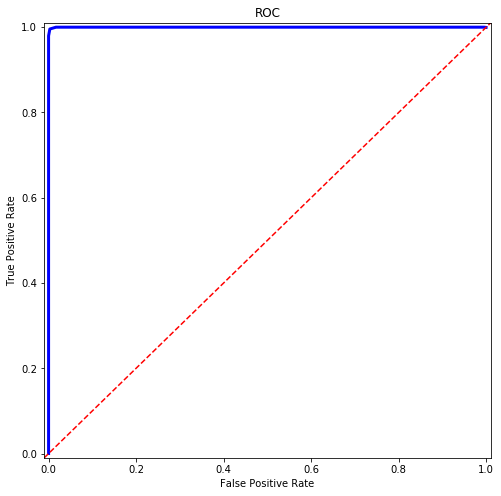

In [615]:
TPR_array = []
FPR_array = []
for i in tqdm(range(-50,51,5)):
    normalized_svm_raw_results = -1*(normalize(svm.predict(x_test, flags=1)[1]) - 1)
    predicted = np.round(normalized_svm_raw_results + i/100).reshape(y_test.shape)
    actual = y_test  
    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))
    
    FP = np.count_nonzero(np.multiply(predicted, actual - 1))
    FN = np.count_nonzero(np.multiply(predicted - 1, actual))

    TPR_array.append(TP / (TP+FN))
    FPR_array.append(FP / (FP+TN))

plot_ROC(TPR_array, FPR_array)

#### PLOT FAR/FRR CURVES

100%|██████████| 120/120 [00:00<00:00, 252.34it/s]


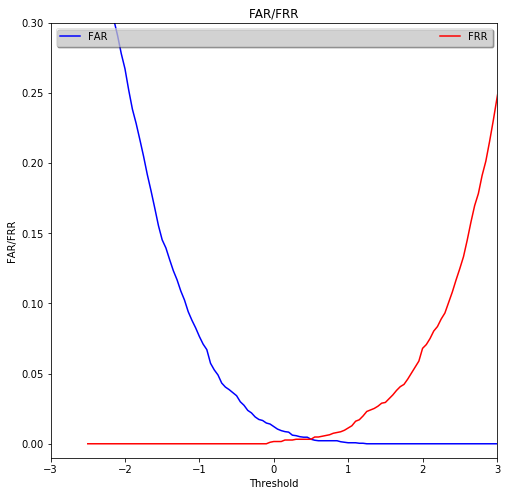

In [616]:
plot_FAR_FRR(svm, x_test, y_test)

#### TRAIN FINAL MODEL

In [617]:
x_train_and_validation = np.asarray([i[0] for i in train_and_validation])
y_train_and_validation = np.asarray([i[1] for i in train_and_validation])

svm.train(x_train_and_validation, cv2.ml.ROW_SAMPLE, y_train_and_validation)

True

## 6. Find faces on images

#### FUNCTION TO SLIDE 64X64 WINDOW OVER DIFFERENT, SCALED IMAGE SIZES TO FIND FACES.

In [618]:
def get_bboxes(path, stride, model, own_implementation=False, threshold=0):
    image = open_image(path, color=False)
#     image = hitogram_equalization(image)
    global_height, global_width = image.shape

    ratio = global_height/global_width

    results = []
    x = 1 if own_implementation else 4
    for i in tqdm(range(1, int(min(global_height, global_width)/IMG_SIZE) + x)):
        img = resize(image, i * IMG_SIZE, int(i * IMG_SIZE*ratio))
        height, width = img.shape

        r_h = global_height / height
        r_w = global_width / width

        for row in range(0, height, stride):
            for col in range(0, width, stride):
                up, bottom, left, right = row, row + IMG_SIZE, col, col + IMG_SIZE
                window = img[up:bottom, left:right]

                if window.shape == (IMG_SIZE, IMG_SIZE):
                    if own_implementation:
                        hist = my_hog.get_features(window).reshape((1, -1))
                    else:
                        hist = hog.compute(window,winStride,padding,locations).reshape((1, -1))
                        
                    prediction = model.predict(hist,flags=1)

                    if prediction[1] < threshold:
                        up_abs = int(up*r_h)
                        bottom_abs = int(bottom*r_h)
                        left_abs = int(left*r_w)
                        right_abs = int(right*r_w)
                        results.append((up_abs, bottom_abs, left_abs, right_abs))
    return results


#### FUNCTION TO JOIN OVERLAPPING BOUNDING BOXES.

In [619]:
def join_bboxes(bboxes):
    results = []
    sorted_bboxes = sorted(bboxes, key=lambda x: x[0]+x[2])

    while len(sorted_bboxes) > 0:
        temp_up, temp_bottom, temp_left, temp_right = sorted_bboxes[0]
        for num, (up, bottom, left, right) in enumerate(sorted_bboxes[1:]):
            if ((temp_up <= up <= temp_bottom) or (temp_up <= bottom <= temp_bottom)) and ((temp_left <= left <= temp_right) or (temp_left <= right <= temp_right)):
                if up <= temp_up:
                    temp_up = up
                if bottom >= temp_bottom:
                    temp_bottom = bottom
                if left <= temp_left:
                    temp_left = left
                if right >= temp_right:
                    temp_right = right
                sorted_bboxes.remove((up, bottom, left, right))
        results.append((temp_up, temp_bottom, temp_left, temp_right))
        sorted_bboxes.pop(0)
    return results


#### FUNCTION TO PLOT BOUNDING BOX AROUND FOUND FACES.

In [620]:
def plot_results(path, bboxes):
    image = open_image(path)
    for up, bottom, left, right in bboxes:                
        for row in range(image.shape[0]):
            for col in range(image.shape[1]):
                if (row == up or row == bottom) and right >= col >= left:
                    try:
                        image[row][col] = 0, 255, 0
                        image[row+1][col] = 0, 255, 0
                        image[row-1][col] = 0, 255, 0
                    except IndexError:
                        continue

                if (col == right or col == left) and bottom >= row >= up:
                    try:
                        image[row][col] = 0, 255, 0
                        image[row][col+1] = 0, 255, 0
                        image[row][col-1] = 0, 255, 0
                    except IndexError:
                        continue

    plt.figure(figsize=(12,10))
    plt.imshow(image[:,:,[2,1,0]])
    plt.show()
    return image

#### SCRIPT FOR FINDING FACES IN THE EVALUTION PICTURES.

100%|██████████| 6/6 [00:01<00:00,  4.57it/s]


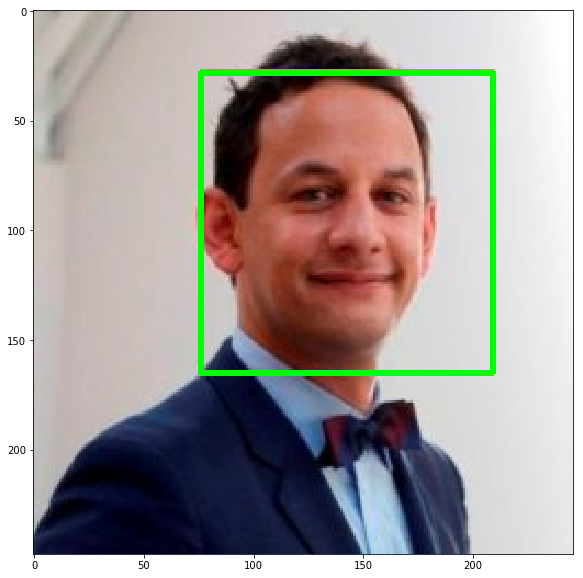

100%|██████████| 9/9 [00:03<00:00,  2.97it/s]


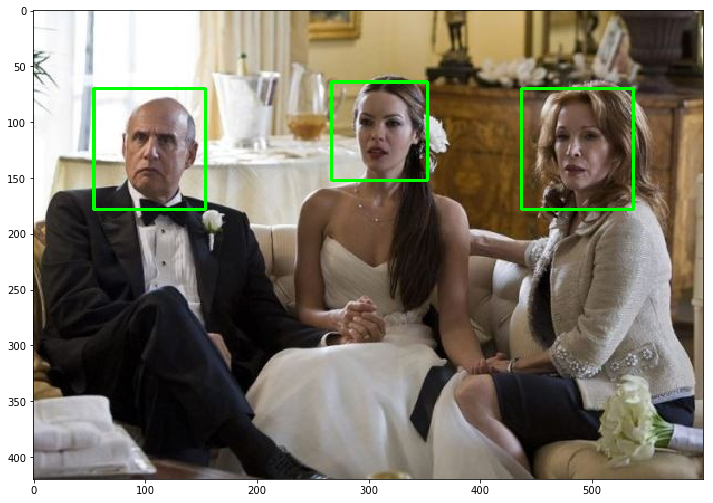

100%|██████████| 10/10 [00:03<00:00,  2.52it/s]


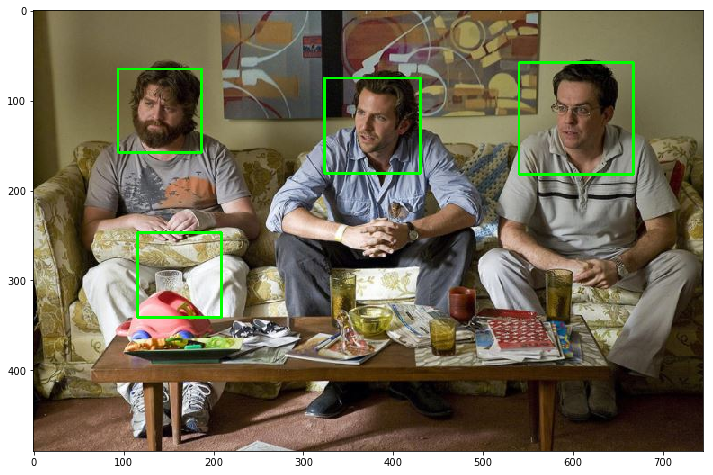

100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


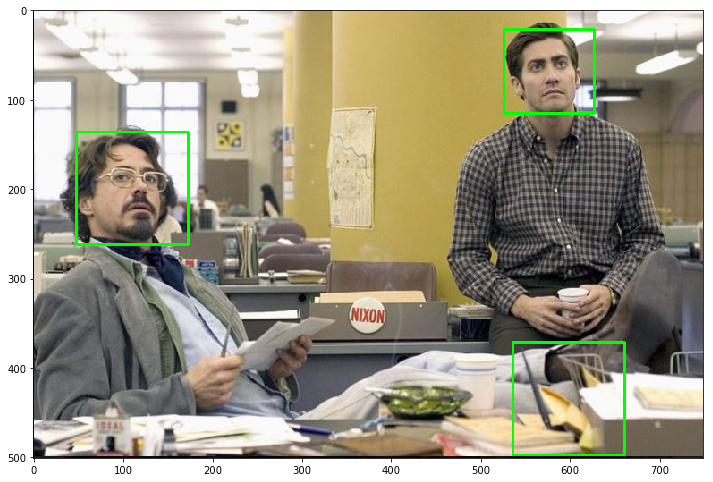

100%|██████████| 9/9 [00:03<00:00,  2.46it/s]


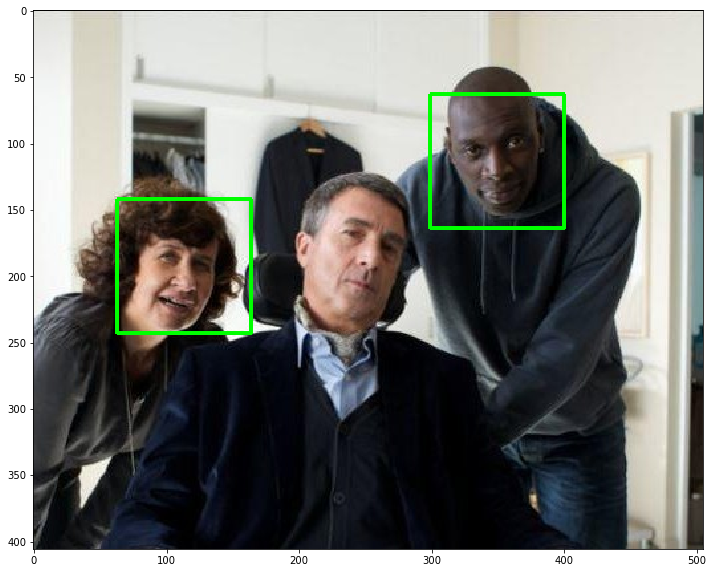

100%|██████████| 7/7 [00:00<00:00, 10.63it/s]


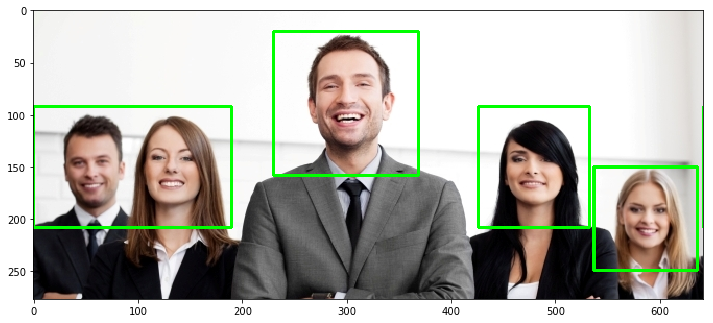

100%|██████████| 6/6 [00:01<00:00,  4.74it/s]


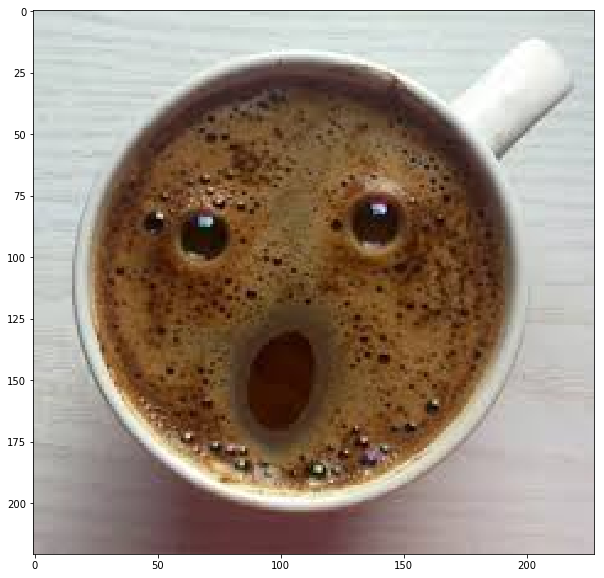

100%|██████████| 5/5 [00:01<00:00,  3.79it/s]


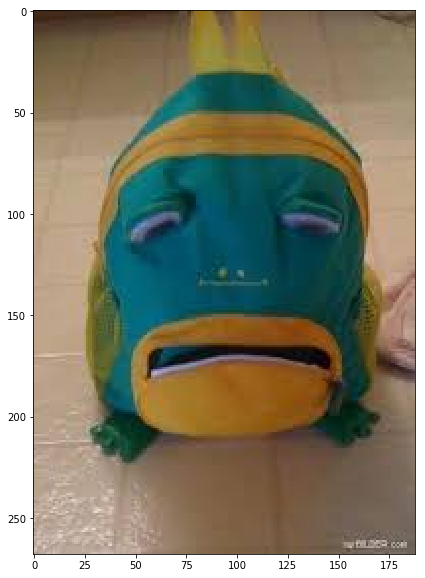

100%|██████████| 5/5 [00:00<00:00, 13.31it/s]


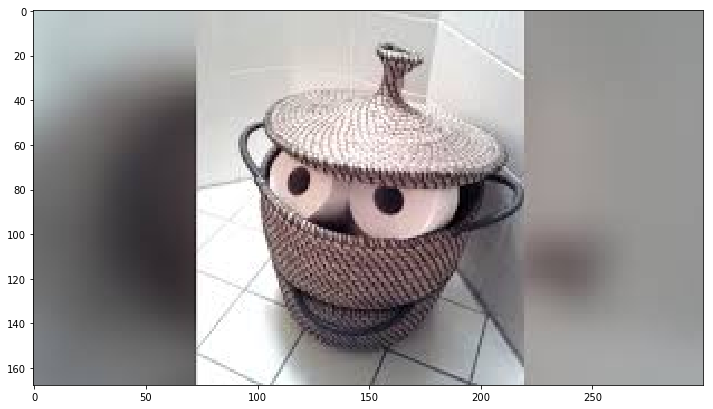

100%|██████████| 6/6 [00:01<00:00,  3.17it/s]


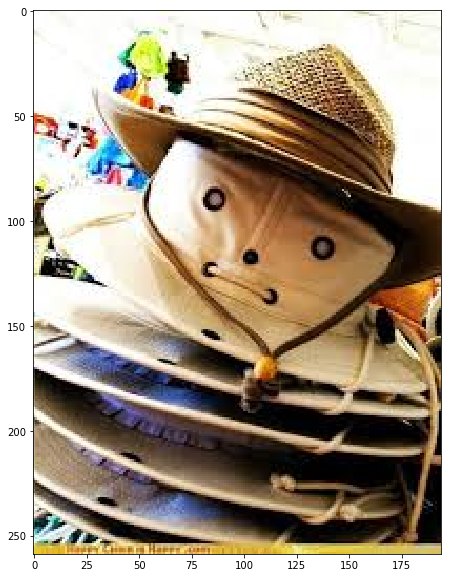

100%|██████████| 6/6 [00:00<00:00,  6.25it/s]


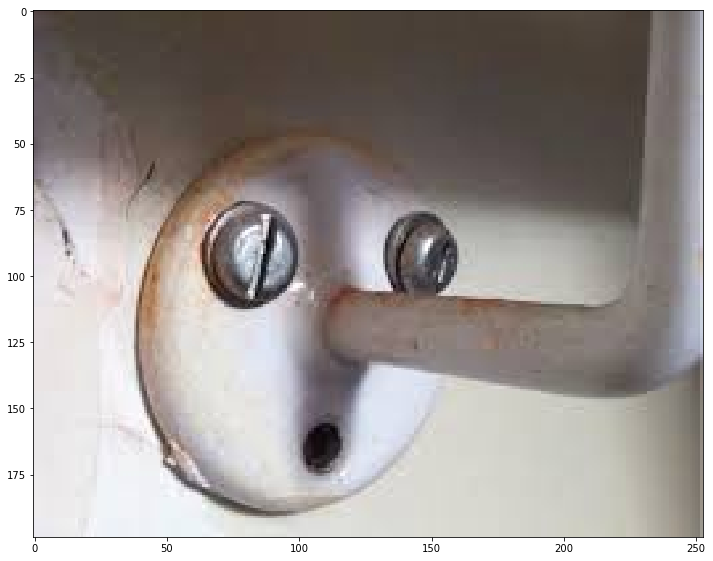

100%|██████████| 6/6 [00:00<00:00,  6.66it/s]


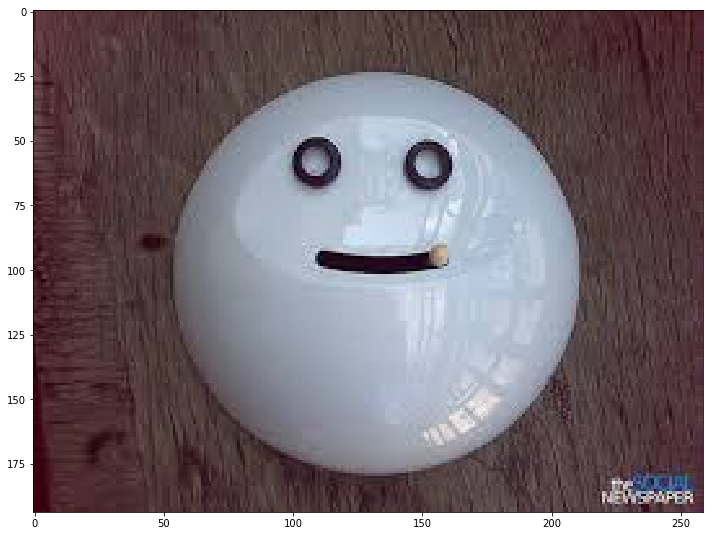

100%|██████████| 6/6 [00:00<00:00,  6.64it/s]


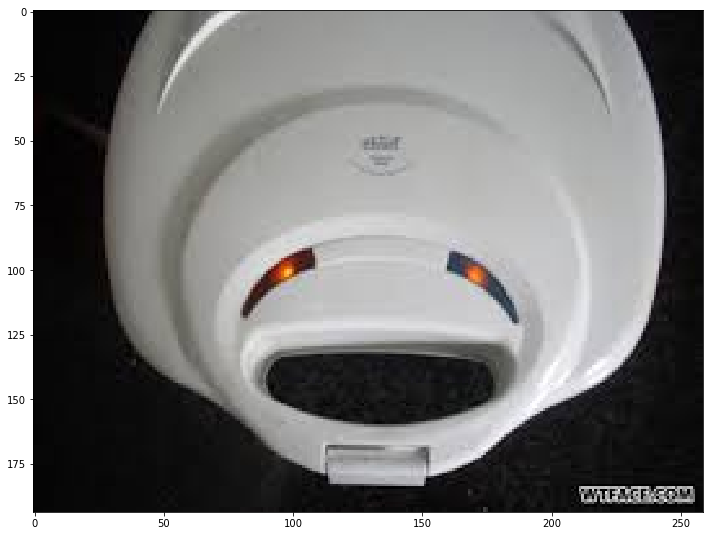

100%|██████████| 6/6 [00:01<00:00,  4.58it/s]


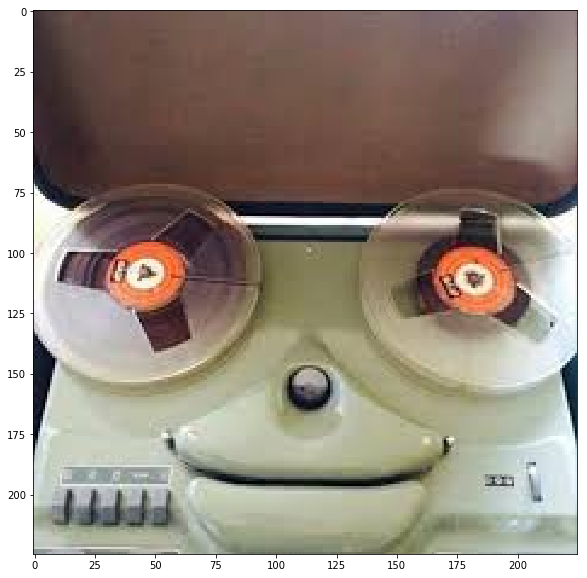

100%|██████████| 6/6 [00:01<00:00,  3.29it/s]


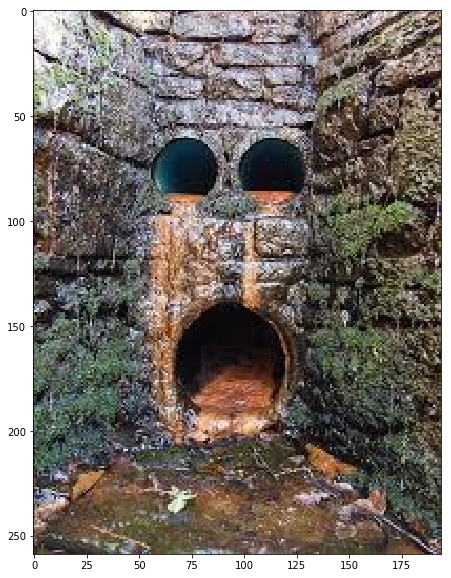

In [643]:
for i in range(1, 16):
    path = jj('data', 'evaluation', '{}.jpg'.format(i))
    bboxes = get_bboxes(path, 5, model=svm, own_implementation=False, threshold=-1.4)
    joined_bboxes = join_bboxes(bboxes)
    image = plot_results(path, joined_bboxes)
    cv2.imwrite(jj('data', 'evaluation', 'result_{}.jpg'.format(i)), image)
    

## 7. OWN IMPLEMENTATION OF HOG ALGORITHM

In [622]:
from skimage.draw import line

class HOG(object):
    def __init__(self, win_size, block_size=16, block_stride=8, cell_size=8, nbins=9):
        self.win_size = win_size
        self.block_size = block_size
        self.block_stride = block_stride
        self.cell_size = cell_size
        self.nbins = nbins
        self.sobel_Gx_filter = np.asarray([[-1, 0, 1],
                                           [-2, 0, 2],
                                           [-1, 0, 1]], dtype=np.int)

        self.sobel_Gy_filter = np.asarray([[-1, -2, -1],
                                           [0, 0, 0],
                                           [1, 2, 1]], dtype=np.int)

        self.height, self.width = self.win_size
  
    def get_features(self, array):
        Gx = self.get_Gx(array)
        Gy = self.get_Gy(array)
        G = self.get_G(Gx, Gy)
        theta = self.get_theta(Gx, Gy)        
        histograms = self.get_histograms_of_gradients(theta, G)
        
        # Normalize in blocks
        features = []
        for row in range(0, histograms.shape[0], int(self.block_stride/self.cell_size)):
            for col in range(0, histograms.shape[1], int(self.block_stride/self.cell_size)):
                hist = histograms[row: row + int(self.block_size / self.cell_size),
                                  col: col + int(self.block_size / self.cell_size)]

                if hist.shape == (int(self.block_size / self.cell_size), int(self.block_size / self.cell_size), self.nbins):
                    features.append(normalize(hist.ravel()))
                    
        return np.asarray(features, dtype=np.float32).ravel().reshape(-1, 1)        
    
    def get_gradients_image(self, array):
        "Get direction of gradient with the biggest magnitude in each cell"
        Gx = self.get_Gx(array)
        Gy = self.get_Gy(array)
        G = self.get_G(Gx, Gy)
        theta = self.get_theta(Gx, Gy)        
        histograms = self.get_histograms_of_gradients(theta, G)
        result = np.zeros((self.height, self.width), dtype=np.int)
        global_max_magnitude = np.max(histograms)
        for row in range(0, int(result.shape[0]/self.cell_size)):
            for col in range(0, int(result.shape[1]/self.cell_size)):
                for direction, magnitude in enumerate(histograms[row][col]):           
                    if direction == 0:
                        line_array = np.zeros((8, 8), dtype=np.uint8)
                        line_array[line(1, 4, 6, 4)] = int(magnitude*255/global_max_magnitude)

                    elif direction == 1:
                        line_array = np.zeros((8, 8), dtype=np.uint8)
                        line_array[line(6, 2, 1, 6)] = int(magnitude*255/global_max_magnitude)

                    elif direction == 2:
                        line_array = np.zeros((8, 8), dtype=np.uint8)
                        line_array[line(6, 1, 1, 5)] = int(magnitude*255/global_max_magnitude)

                    elif direction == 3:
                        line_array = np.zeros((8, 8), dtype=np.uint8)
                        line_array[line(5, 1, 1, 6)] = int(magnitude*255/global_max_magnitude)

                    elif direction == 4:
                        line_array = np.zeros((8, 8), dtype=np.uint8)
                        line_array[line(4, 1, 4, 6)] = int(magnitude*255/global_max_magnitude)

                    elif direction == 5:
                        line_array = np.zeros((8, 8), dtype=np.uint8)
                        line_array[line(2, 1, 5, 6)] = int(magnitude*255/global_max_magnitude)

                    elif direction == 6:
                        line_array = np.zeros((8, 8), dtype=np.uint8)
                        line_array[line(1, 1, 6, 6)] = int(magnitude*255/global_max_magnitude)

                    elif direction == 7:
                        line_array = np.zeros((8, 8), dtype=np.uint8)
                        line_array[line(1, 2, 6, 6)] = int(magnitude*255/global_max_magnitude)

                    elif direction == 8:
                        line_array = np.zeros((8, 8), dtype=np.uint8)                    
                        line_array[line(1, 3, 6, 4)] = int(magnitude*255/global_max_magnitude)

                    result[row * self.cell_size: row * self.cell_size + self.cell_size,
                           col * self.cell_size: col * self.cell_size + self.cell_size] += line_array
                
        return result
    
    def get_Gx(self, array):
        zero_padded_array = np.pad(array, 1, mode='constant')
        return self.convolve(zero_padded_array, self.sobel_Gx_filter)

    def get_Gy(self, array):
        zero_padded_array = np.pad(array, 1, mode='constant')
        return self.convolve(zero_padded_array, self.sobel_Gy_filter)

    def get_G(self, Gx, Gy):
        return np.sqrt(np.square(Gx) + np.square(Gy))

    def get_theta(self, Gx, Gy):
        """Result is in radians from -π to π"""
        return np.arctan2(Gy, Gx)
          
    def get_histograms_of_gradients(self, theta, G):
        normalized_theta =  theta / np.pi
        normalized_theta = np.where(normalized_theta > 0, normalized_theta, normalized_theta+1)
        b_step = 1.0/self.nbins
        b_bottom = normalized_theta // b_step
        b_bottom[b_bottom>=self.nbins] = 0
        b_top = b_bottom + 1
        b_top[b_top>=self.nbins] = 0
        b_delta = (normalized_theta % b_step) / b_step
        bins = np.zeros((self.height, self.width, self.nbins))       
        for i in range(self.nbins):
            bins[:,:,i] += np.where(b_bottom==i,(1-b_delta),0)
            bins[:,:,i] += np.where(b_top==i, b_delta, 0)
            
        for row in range(self.height):
            for col in range(self.width):
                bins[row][col] *= G[row][col]   
        
        histograms = []
        for row in range(0, int(self.height / self.cell_size)):
            for col in range(0, int(self.width / self.cell_size)):
                hist = bins[row * self.cell_size: row * self.cell_size + self.cell_size,
                            col * self.cell_size: col * self.cell_size + self.cell_size,:].sum(axis=0).sum(axis=0)
                histograms.append(hist)
        return np.array(histograms).reshape((int(self.height / self.cell_size), int(self.width / self.cell_size), self.nbins))

    def convolve(self, array, filter_array):
        result_array = np.zeros((self.height, self.width), dtype=np.int)
        offset = filter_array.shape[0] // 2
        for row in range(self.height):
            for col in range(self.width):
                if (self.height - 2 * offset >= row >= offset) and (self.width - 2 * offset >= col >= offset):
                    new_value = 0
                    for f_row in range(filter_array.shape[0]):
                        for f_col in range(filter_array.shape[1]):
                            new_value += array[row - offset + f_row][col - offset + f_col] * filter_array[f_row][f_col]
                    result_array[row - offset, col - offset] = new_value
        return result_array

#### CREATE INSTANCE OF HOG MODEL.

In [623]:
winSize = (64, 64)
blockSize = 16
blockStride = 8
cellSize = 8
nbins = 9

my_hog = HOG(winSize,blockSize,blockStride,cellSize,nbins)

#### PLOT GRADIENT DIRECTIONS ON THE SAMPLE IMAGE USING IMPLEMENTED HOG ALGORITHM.

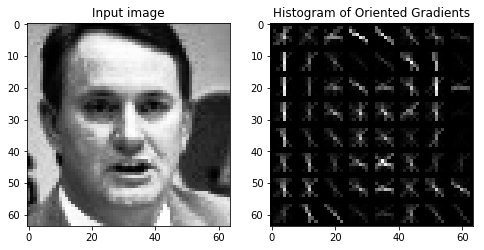

In [624]:
image = open_image(jj(FACES_64, 'f_80.jpg'), color=False)

image = hitogram_equalization(image)
hist = my_hog.get_features(image)
grad = my_hog.get_gradients_image(image)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

ax2.imshow(grad, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

#### SCRIPTS USED TO OBTAIN HOG FEATURES FROM IMAGES, BUILD DATASET AND SAVE IT.

In [625]:
# # Get HOG features of all faces images
# faces = []
# for i in tqdm(range(NUMBER_OF_FACES)):
#     img = open_image(jj(FACES_64, 'f_{}.jpg'.format(i)), color=False)
# #     img = hitogram_equalization(img)
# #     img = resize(img, IMG_SIZE)
# #     face_hist = hog.compute(img,winStride,padding,locations)
#     face_hist = my_hog.get_features(img)
#     faces.append((face_hist, 1))

In [626]:
# # Get HOG features of all other images
# others = []
# for i in tqdm(range(NUMBER_OF_OTHERS)):
#     img = open_image(jj(OTHER_64, 'o_{}.jpg'.format(i)), color=False)
# #     img = hitogram_equalization(img)
# #     img = resize(img, IMG_SIZE)
# #     other_hist = hog.compute(img,winStride,padding,locations)
#     other_hist = my_hog.get_features(img)
#     others.append((other_hist, 0))

In [627]:
# # Get HOG features of all other with faces images
# others_with_faces = []
# for i in tqdm(range(NUMBER_OF_OTHER_WITH_FACES)):
#     img = open_image(jj(OTHER_WITH_FACES_64, 'o_{}.jpg'.format(i)), color=False)
# #     img = hitogram_equalization(img) 
# #     img = resize(img, IMG_SIZE)
# #     other_hist = hog.compute(img,winStride,padding,locations)
#     other_hist = my_hog.get_features(img)
#     others_with_faces.append((other_hist, 0))

In [628]:
# # Build dataset
# dataset_own = faces + others + others_with_faces
# random.shuffle(dataset_own)
# print(len(dataset_own))


#### SCRIPT FOR SPLIT DATASET TO TRAINING AND VALIDATION  DATASET AND TEST DATASET AND EXPORT DATA.

In [629]:
# train_and_validation_own, test_own = split_data(dataset_own, train_size=0.75)

In [630]:
x_test_own = np.asarray([i[0] for i in test_own])
y_test_own = np.asarray([i[1] for i in test_own])

In [631]:
# # export train_and_validation_own and test_own dataset
# pickle.dump( train_and_validation_own, open(os.path.join("data", "train_and_validation_dataset_own.data"), "wb" ))
# pickle.dump( test_own, open(os.path.join("data", "test_dataset_own.data"), "wb" ))

## 8. Create and evaluate SVM model

#### CREATE SVM MODEL USING OPENCV. 

In [632]:
svm_own = cv2.ml.SVM_create()
svm_own.setKernel(cv2.ml.SVM_LINEAR)
svm_own.setType(cv2.ml.SVM_C_SVC)
svm_own.setC(1)
svm_own.setGamma(1)

#### EVALUATE ON VALIDATION DATASET USING K_FOLD VALIDATION.

In [633]:
k_fold_split_array_own = k_fold_split_data(train_and_validation_own, 10)
train_accuracies_own = []
validation_accuracies_own = []

for n, validation_own in enumerate(k_fold_split_array_own):
    train_own = k_fold_split_array_own.copy()
    train_own.pop(n)
    train_own = np.concatenate(train_own)

    x_train_own = np.asarray([i[0] for i in train_own])
    y_train_own = np.asarray([i[1] for i in train_own])

    x_validation_own = np.asarray([i[0] for i in validation_own])
    y_validation_own = np.asarray([i[1] for i in validation_own])

    svm_own.train(x_train_own, cv2.ml.ROW_SAMPLE, y_train_own)
    
    y_pred_own = svm_own.predict(x_train_own)[1]
    train_accuracies_own.append(accuracy_score(y_train_own, y_pred_own))
    
    y_pred_own = svm_own.predict(x_validation_own)[1]
    validation_accuracies_own.append(accuracy_score(y_validation_own, y_pred_own))

print("Training accuracy: {}".format(np.average(train_accuracies_own)))
print("Validation accuracy: {}".format(np.average(validation_accuracies_own)))

Training accuracy: 1.0
Validation accuracy: 0.9922666666666666


#### EVALUATE ON TEST DATASET.

In [634]:
# Evaluate model on test dataset
y_pred_own = svm_own.predict(x_test_own)[1]
accuracy_score(y_test_own, y_pred_own)

0.9933333333333333

#### PLOT CONFUSION MATRIX FOR TEST DATASET.

In [635]:
plot_confusion_matrix(svm_own, x_test_own, y_test_own)

Acuraccy: 0.9933333333333333

Precision: 0.99185667752443
Recall: 0.994556341861731
F-score: 0.9932046751834739


             actual 1  actual 0
predicted 1      1827        15
predicted 0        10      1898


#### PLOT CONFUSION MATRIX WITH CHOSEN THRESHOLD TO GET SUPER HIGHT PRECISION

In [646]:
plot_confusion_matrix(svm_own, x_test_own, y_test_own, threshold=-1.2)

Acuraccy: 0.9818666666666667

Precision: 0.9988719684151156
Recall: 0.9640718562874252
F-score: 0.9811634349030471


             actual 1  actual 0
predicted 1      1771         2
predicted 0        66      1911


#### PLOT ROC CURVE (RECEIVER OPERATING CHARACTERISTIC.

100%|██████████| 21/21 [00:00<00:00, 263.35it/s]
/home/maciejpesko/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


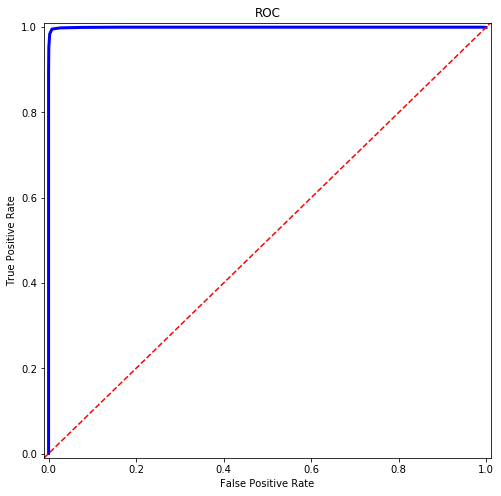

In [637]:
TPR_array = []
FPR_array = []
for i in tqdm(range(-50,55,5)):
    normalized_svm_raw_results = -1*(normalize(svm_own.predict(x_test_own, flags=1)[1]) - 1)
    predicted = np.round(normalized_svm_raw_results + i/100).reshape(y_test_own.shape)
    actual = y_test_own  
    TP = np.count_nonzero(np.multiply(predicted, actual))
    TN = np.count_nonzero(np.multiply(predicted - 1, actual - 1))
    FP = np.count_nonzero(np.multiply(predicted, actual - 1))
    FN = np.count_nonzero(np.multiply(predicted - 1, actual))

    TPR_array.append(TP / (TP+FN))
    FPR_array.append(FP / (FP+TN))

plot_ROC(TPR_array, FPR_array)

#### PLOT FAR/FRR CURVES

100%|██████████| 120/120 [00:00<00:00, 320.72it/s]


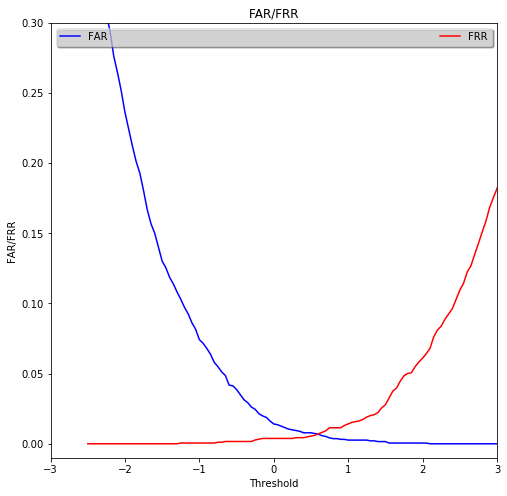

In [638]:
plot_FAR_FRR(svm_own, x_test_own, y_test_own)

#### TRAIN FINAL MODEL

In [639]:
x_train_and_validation_own = np.asarray([i[0] for i in train_and_validation_own])
y_train_and_validation_own = np.asarray([i[1] for i in train_and_validation_own])

svm_own.train(x_train_and_validation_own, cv2.ml.ROW_SAMPLE, y_train_and_validation_own)

True

## 9. Find faces on sample images (slow)

100%|██████████| 3/3 [00:37<00:00, 12.40s/it]


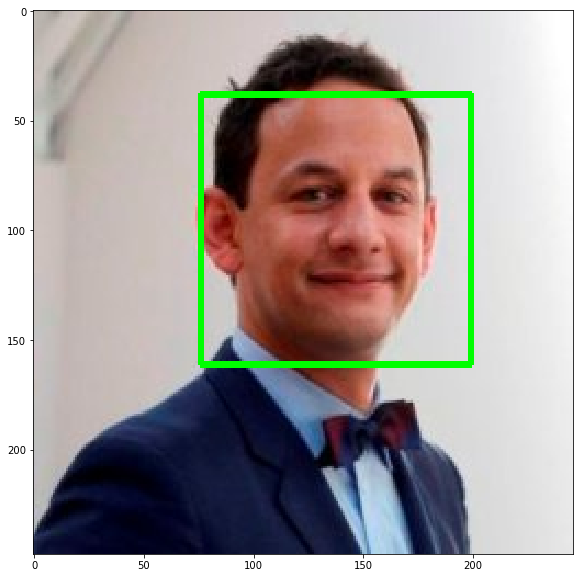

100%|██████████| 6/6 [04:13<00:00, 42.26s/it]


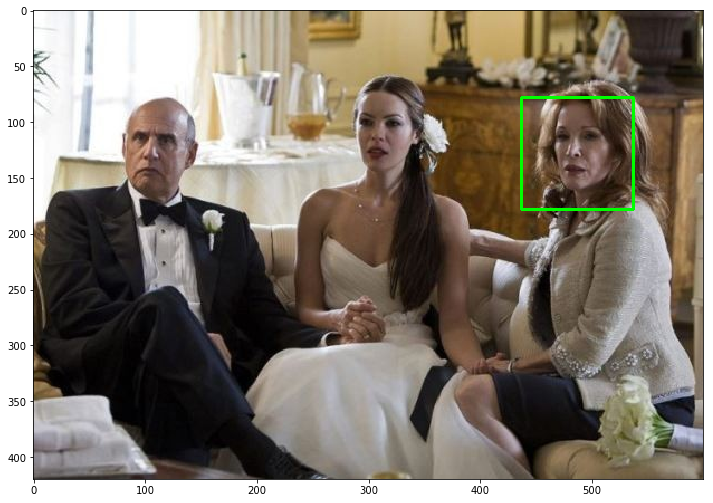

In [644]:
for i in range(1, 3):
    path = jj('data', 'evaluation', '{}.jpg'.format(i))
    bboxes = get_bboxes(path, 10, model=svm_own, own_implementation=True, threshold=-1.2)
    joined_bboxes = join_bboxes(bboxes)
    image = plot_results(path, joined_bboxes)    

100%|██████████| 2/2 [00:14<00:00,  7.48s/it]


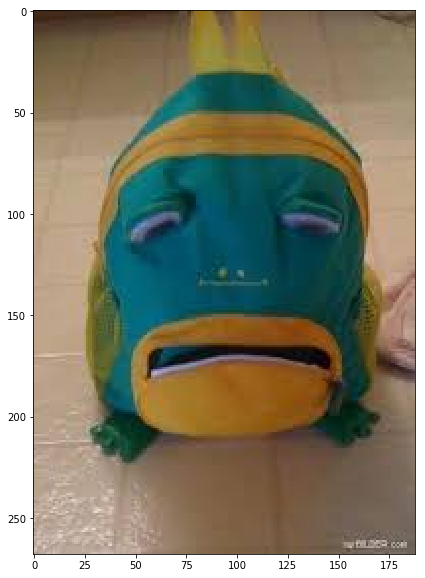

100%|██████████| 2/2 [00:01<00:00,  1.67it/s]


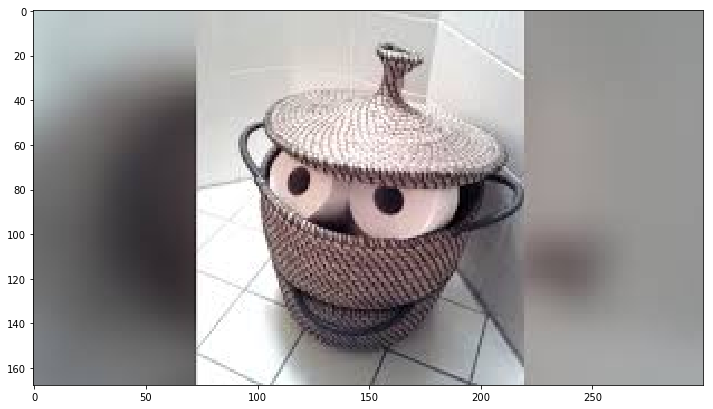

In [647]:
for i in range(8, 10):
    path = jj('data', 'evaluation', '{}.jpg'.format(i))
    bboxes = get_bboxes(path, 10, model=svm_own, own_implementation=True, threshold=-1.2)
    joined_bboxes = join_bboxes(bboxes)
    image = plot_results(path, joined_bboxes)    